Preprocess both weather and traffic collision data and conduct data cleaning.  
Build data models for both datasets and find relationships between them.

In [1]:
# download json data
import requests
import json

url = 'https://project551-1f44c.firebaseio.com/weather.json'
response = requests.get(url)
data = response.json()
print(response)

with open('weather.json','w',encoding='utf-8') as file:
    file.write(json.dumps(data,indent=2,ensure_ascii=False))
    
url = 'https://project551-1f44c.firebaseio.com/traffic.json'
response = requests.get(url)
data = response.json()
print(response)

with open('traffic.json','w',encoding='utf-8') as file:
    file.write(json.dumps(data,indent=2,ensure_ascii=False))

<Response [200]>
<Response [200]>


In [18]:
# weather = pd.read_csv("data/weather/weather_description.csv", sep=',')
# weather = weather[['datetime', 'Los Angeles']]
# print(weather)
# traffic = pd.read_csv("data/traffic/traffic-collision-data-from-2010-to-present.csv", sep=',')
# traffic = traffic[['Date Occurred', 'Time Occurred', 'Area Name']]
# print(traffic)

In [3]:
import pandas as pd

# weather data
weather = pd.read_json('weather.json')
weather_data = {'date':[], 'hour': [], 'weather': []}
for date in weather:
    for hour, info in enumerate(weather[date]):
        if type(info) is str:
            weather_data['date'].append(date)
            weather_data['hour'].append(hour)
            weather_data['weather'].append(info)
        else:
            weather_data['date'].append(date)
            weather_data['hour'].append(hour)
            weather_data['weather'].append(None)
weather_df = pd.DataFrame(weather_data)
print(weather_df)

            date  hour       weather
0     2012-10-01     0  sky is clear
1     2012-10-01     1              
2     2012-10-01     2          mist
3     2012-10-01     3  sky is clear
4     2012-10-01     4  sky is clear
...          ...   ...           ...
45259 2017-11-29    19  sky is clear
45260 2017-11-29    20  sky is clear
45261 2017-11-29    21  sky is clear
45262 2017-11-29    22  sky is clear
45263 2017-11-29    23  sky is clear

[45264 rows x 3 columns]


In [4]:
# traffic data
traffic = pd.read_json('traffic.json')
traffic_data = {'date':[], 'hour': [], 'area': [], 'collision': []}
for date in traffic:
    for hour, info in enumerate(traffic[date]):
        if type(info) is dict: 
            for area in info:
                traffic_data['date'].append(date)
                traffic_data['hour'].append(hour)
                traffic_data['area'].append(area)
                traffic_data['collision'].append(info[area])
        else:
            traffic_data['date'].append(date)
            traffic_data['hour'].append(hour)
            traffic_data['area'].append(None)
            traffic_data['collision'].append(0)
traffic_df = pd.DataFrame(traffic_data)
print(traffic_df)

             date  hour         area  collision
0      2010-01-01     0  77th Street          3
1      2010-01-01     0     Foothill          1
2      2010-01-01     0       Harbor          1
3      2010-01-01     0   Hollenbeck          1
4      2010-01-01     0    Southwest          1
...           ...   ...          ...        ...
421804 2019-11-30    19         None          0
421805 2019-11-30    20         None          0
421806 2019-11-30    21         None          0
421807 2019-11-30    22         None          0
421808 2019-11-30    23         None          0

[421809 rows x 4 columns]


In [7]:
set(traffic_df.area)

{'77th Street',
 'Central',
 'Devonshire',
 'Foothill',
 'Harbor',
 'Hollenbeck',
 'Hollywood',
 'Mission',
 'N Hollywood',
 'Newton',
 None,
 'Northeast',
 'Olympic',
 'Pacific',
 'Rampart',
 'Southeast',
 'Southwest',
 'Topanga',
 'Van Nuys',
 'West LA',
 'West Valley',
 'Wilshire'}

In [58]:
df = pd.merge(weather_df, traffic_df)
print(df)

             date  hour       weather        area  collision
0      2012-10-01     0  sky is clear        None          0
1      2012-10-01     1                      None          0
2      2012-10-01     2          mist     Mission          1
3      2012-10-01     2          mist     Olympic          1
4      2012-10-01     2          mist     Topanga          1
...           ...   ...           ...         ...        ...
221770 2017-11-29    22  sky is clear     West LA          2
221771 2017-11-29    23  sky is clear    Foothill          1
221772 2017-11-29    23  sky is clear  Hollenbeck          1
221773 2017-11-29    23  sky is clear     Rampart          1
221774 2017-11-29    23  sky is clear   Southwest          1

[221775 rows x 5 columns]


In [75]:
df0 = df.groupby(['date','hour', 'weather']) # .agg(sum_collision=pd.NamedAgg('collision', 'sum'))
df0 = pd.DataFrame(df0.sum()).reset_index()
df0 = df0[13:] # 不要2012-10-01的数据 因为weather有missing value
print(df0)

            date  hour       weather  collision
13    2012-10-02     0  sky is clear          1
14    2012-10-02     1  sky is clear          2
15    2012-10-02     2  sky is clear          3
16    2012-10-02     3          mist          1
17    2012-10-02     4           fog          1
...          ...   ...           ...        ...
45248 2017-11-29    19  sky is clear         12
45249 2017-11-29    20  sky is clear          5
45250 2017-11-29    21  sky is clear          3
45251 2017-11-29    22  sky is clear          7
45252 2017-11-29    23  sky is clear          4

[45240 rows x 4 columns]


In [181]:
# 不同天气下平均每小时的车祸次数
df1 = df0.groupby('weather').agg(count_hour=pd.NamedAgg('weather','count'),sum_collision=pd.NamedAgg('collision', 'sum'))
df1 = pd.DataFrame(df1).reset_index()
df1['ave_collision'] = df1.apply(lambda x: x['sum_collision']/x['count_hour'], axis=1)
df1 = df1.sort_values(by='ave_collision').reset_index(drop=True)
print(df1)

rare_weather = df1[df1['count_hour']<30]['weather'].values
# print(rare_weather)

                         weather  count_hour  sum_collision  ave_collision
0         thunderstorm with rain           2              2       1.000000
1                            fog         566           2190       3.869258
2                        squalls           3             13       4.333333
3                           mist        2960          14581       4.926014
4   thunderstorm with light rain          13             69       5.307692
5                           haze        3532          18902       5.351642
6                     light rain        1949          10590       5.433556
7        light intensity drizzle         104            569       5.471154
8           heavy intensity rain         127            696       5.480315
9                very heavy rain          20            110       5.500000
10                   shower rain           8             44       5.500000
11               overcast clouds        2432          13495       5.548931
12              scattered

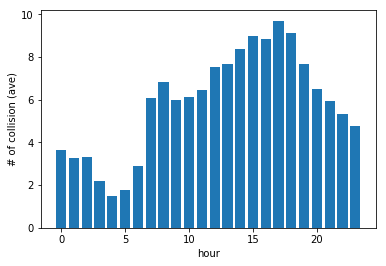

In [82]:
# 不同日期同一小时内的平均车祸次数
import matplotlib.pyplot as plt

df2 = df0.groupby('hour').agg(count=pd.NamedAgg('hour','count'),sum_collision=pd.NamedAgg('collision', 'sum'))
df2 = pd.DataFrame(df2).reset_index()
df2['ave_collision'] = df2.apply(lambda x: x['sum_collision']/x['count'], axis=1)
# df2 = df2.sort_values(by='ave_collision').reset_index(drop=True)[['hour', 'ave_collision']]
# print(df2[['hour', 'ave_collision']])

x_data = df2['hour']
y_data = df2['ave_collision']
plt.bar(x=x_data, height=y_data)
plt.xlabel('hour')
plt.ylabel('# of collision (ave)')
plt.show()

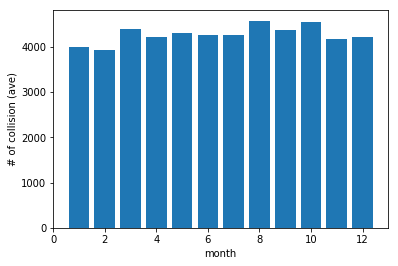

In [164]:
# 不同月的平均车祸次数
df4 = df0.copy(deep=True)
df4['date'] = pd.to_datetime(df4['date'],format='%Y-%m-%d')
df4['year'] = df4['date'].dt.year
df4['month'] = df4['date'].dt.month
df4['day'] = df4['date'].dt.day
df5 = df4.groupby('month').agg(sum_collision=pd.NamedAgg('collision', 'sum'))
df5 = pd.DataFrame(df5).reset_index()
df5['ave_collision'] = df5.apply(lambda x: x['sum_collision']/6 if x['month']==11 or x['month']==10 else x['sum_collision']/5, axis=1)
# print(df5)

x_data = df5['month']
y_data = df5['ave_collision']
plt.bar(x=x_data, height=y_data)
plt.xlabel('month')
plt.ylabel('# of collision (ave)')
plt.show()

In [186]:
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

df3 = df0.copy(deep=True)
df3 = df3[~df3['weather'].isin(rare_weather)]
# print(df3)
X = df3.iloc[:, :-1]
y = df3.iloc[:, -1]

# X['date'] = pd.to_datetime(X['date'],format='%Y-%m-%d')
# X['month'] = X['date'].dt.month
# X['day'] = X['date'].dt.day
X.drop('date', axis=1, inplace=True)
X = pd.get_dummies(X, prefix=['weather'])  # 独热编码
# X.iloc[:,1] = OrdinalEncoder().fit_transform(np.array(X.iloc[:,1]).reshape(-1, 1))  # 特征工程专用编码
# print(X)

            date  hour       weather  collision
13    2012-10-02     0  sky is clear          1
14    2012-10-02     1  sky is clear          2
15    2012-10-02     2  sky is clear          3
16    2012-10-02     3          mist          1
17    2012-10-02     4           fog          1
...          ...   ...           ...        ...
45248 2017-11-29    19  sky is clear         12
45249 2017-11-29    20  sky is clear          5
45250 2017-11-29    21  sky is clear          3
45251 2017-11-29    22  sky is clear          7
45252 2017-11-29    23  sky is clear          4

[45138 rows x 4 columns]


In [187]:
# RandomForest
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y,random_state=1, train_size=0.7) # stratify=X['weather']
 
clf = RandomForestRegressor(max_features=None, max_depth=None,min_samples_split=2, bootstrap=True)
clf.fit(x_train, y_train)

scores = cross_val_score(clf, x_train, y_train)
print(scores.mean())

0.3989363001475826


In [170]:
## LogisticRegression
# from sklearn.linear_model import LogisticRegression

# lr = LogisticRegression(max_iter=1000)
# lr.fit(x_train, y_train)
 
# pre = lr.predict_proba(x_test)
# acc = lr.score(x_test,y_test)
# print(acc)